In [1]:
import warnings

import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import re

from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_selection import VarianceThreshold

import torch
from tqdm import tqdm

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
from transformers import AutoTokenizer, DistilBertModel 

pd.options.display.max_columns = 100


In [2]:
import matplotlib as mlp

mlp.rcParams['lines.linewidth'] = 5

mlp.rcParams['xtick.major.size'] = 20
mlp.rcParams['xtick.major.width'] = 5
mlp.rcParams['xtick.labelsize'] = 20
mlp.rcParams['xtick.color'] = '#FF5533'

mlp.rcParams['ytick.major.size'] = 20
mlp.rcParams['ytick.major.width'] = 5
mlp.rcParams['ytick.labelsize'] = 20
mlp.rcParams['ytick.color'] = '#FF5533'

mlp.rcParams['axes.labelsize'] = 20
mlp.rcParams['axes.titlesize'] = 20
mlp.rcParams['axes.titlecolor'] = '#00B050'
mlp.rcParams['axes.labelcolor'] = '#00B050'

# Feature preparation

Loading data

In [3]:
pip install psycopg2-binary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 8.0 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Set up connection string
connection = ('There must be login and password to access server')

# users info
users = pd.read_sql(
    """
    SELECT * 
      FROM public.user_data
    
    """,
    con=connection
)

# posts info
posts = pd.read_sql(
    """
    SELECT * 
      FROM public.post_text_df
    
    """,
    con=connection
)

# feed data
# action = 'veiw' is target: 1 - like, 0 - just view
feed = pd.read_sql(
    """
    SELECT * 
      FROM public.feed_data 
     WHERE public.feed_data.action = 'view' 
     LIMIT 1000000
     
    """,
    con=connection
)

In [5]:
# Get additional data

# user's activity and likes
user_likes = pd.read_sql(
    """
    SELECT
        public.feed_data.user_id "user_id", 
        count(public.feed_data.target) + sum(public.feed_data.target) "total_user_activity", 
        sum(public.feed_data.target) "user_likes"
    FROM 
        public.feed_data 
    LEFT JOIN 
        public.user_data on public.user_data.user_id = public.feed_data.user_id 
    WHERE 
        public.feed_data.action = 'view' 
    GROUP BY 
        public.feed_data.user_id
   
    """,
    con=connection
)

# post's category likes 
user_cat_likes = pd.read_sql(
    """
    SELECT 
        public.feed_data.user_id "user_id", 
        public.post_text_df.topic "topic",
        sum(public.feed_data.target) "category_likes"
    FROM 
        public.feed_data 
    LEFT JOIN 
        public.post_text_df on public.feed_data.post_id = public.post_text_df.post_id 
    WHERE
        public.feed_data.action = 'view' 
    GROUP BY 
        public.feed_data.user_id, public.post_text_df.topic
    HAVING 
        sum(public.feed_data.target) != 0
   
    """,
    con=connection
)

# mean target for cities 
city_means_target = pd.read_sql(
    """
    SELECT
        public.user_data.city "city", 
        sum(public.feed_data.target) "target_city_likes",
        count(public.feed_data.target) "target_city_activity"
    FROM 
        public.feed_data 
    LEFT JOIN 
        public.user_data on public.user_data.user_id = public.feed_data.user_id 
    WHERE 
        public.feed_data.action = 'view' 
    GROUP BY
        public.user_data.city
   
    """,
    con=connection
)

# mean target for coutries
country_means_target = pd.read_sql(
    """
    SELECT
        public.user_data.country "country", 
        sum(public.feed_data.target) "target_country_likes",
        count(public.feed_data.target) "target_country_activity"
    FROM 
        public.feed_data 
    LEFT JOIN 
        public.user_data on public.user_data.user_id = public.feed_data.user_id 
    WHERE
        public.feed_data.action = 'view' 
    GROUP BY 
        public.user_data.country

    """,
    con=connection
)

### users

In [6]:
# find favourite user's category
user_fav_cat = (
    user_cat_likes
    .loc[user_cat_likes.groupby('user_id')['category_likes'].idxmax()]
    .drop('category_likes', axis=1)
    .rename(columns={'topic' : 'fav_category'})
)

# merging users and likes
user_data = users.merge(user_likes, how='left', on='user_id')
# find share of likes to total activity
user_data['share_of_likes'] = user_data['user_likes']/user_data['total_user_activity']
# adding data for your favorite category
user_data = user_data.merge(user_fav_cat, how='left', on='user_id')
# merging city mean target
user_data = user_data.merge(city_means_target, how='left', on='city')
# making a column with an mean target for the city
user_data['city'] = user_data.target_city_likes/user_data.target_city_activity
# adding data on the mean target for country
user_data = user_data.merge(country_means_target, how='left', on='country')
# making a column with an mean target for the country
user_data['country'] = user_data.target_country_likes/user_data.target_country_activity

# removing unnecessary columns to eliminate collinearity
user_data = user_data.drop([
    'user_likes', 'target_city_likes', 
    'target_city_activity', 'country',
    'target_country_likes', 'target_country_activity'
], axis=1)

In [7]:
user_data.head()

,user_id,gender,age,city,exp_group,os,source,total_user_activity,share_of_likes,fav_category
0,200,1,34,0.130946,3,Android,ads,401,0.107232,movie
1,201,0,37,0.137729,0,Android,ads,748,0.077540,movie
2,202,1,17,0.151418,4,Android,ads,724,0.120166,movie
3,203,0,18,0.154799,1,iOS,ads,382,0.159686,movie
4,204,0,36,0.138011,3,Android,ads,161,0.142857,movie


### posts

Let's get posts' embeddings

In [8]:
tokenizer=AutoTokenizer.from_pretrained('distilbert-base-cased')
model=DistilBertModel.from_pretrained('distilbert-base-cased')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
# making a dataset for posts
class PostDataset(Dataset):
    def __init__(self, texts, tokenizer):
        super().__init__()

        self.texts = tokenizer.batch_encode_plus(
            texts,
            add_special_tokens=True,
            return_token_type_ids=False,
            return_tensors='pt',
            truncation=True,
            padding=True
        )
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        return {
            'input_ids': self.texts['input_ids'][idx], 
            'attention_mask': self.texts['attention_mask'][idx]
        }

    def __len__(self):
        return len(self.texts['input_ids'])
    
    
dataset = PostDataset(posts['text'].values.tolist(), tokenizer)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

loader = DataLoader(dataset, batch_size=32, collate_fn=data_collator, pin_memory=True, shuffle=False)

b = next(iter(loader))

b

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'input_ids': tensor([[  101,  1993,  4190,  ...,     0,     0,     0],
        [  101, 15386,  1116,  ...,  1300,  1107,   102],
        [  101,  3141,   186,  ..., 14099,  8478,   102],
        ...,
        [  101, 16972, 20647,  ...,     0,     0,     0],
        [  101,   137,   188,  ...,     0,     0,     0],
        [  101,   144, 22731,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [10]:
@torch.inference_mode()
def get_embeddings_labels(model, loader):
    model.eval()
    
    total_embeddings = []
    
    for batch in tqdm(loader):
        batch = {key: batch[key].to(device) for key in ['attention_mask', 'input_ids']}

        embeddings = model(**batch)['last_hidden_state'][:, 0, :]

        total_embeddings.append(embeddings.cpu())

    return torch.cat(total_embeddings, dim=0)

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

model = model.to(device)

cuda:0
Tesla P100-PCIE-16GB


In [12]:
embeddings = get_embeddings_labels(model, loader).numpy()

embeddings

100%|██████████| 220/220 [00:59<00:00,  3.72it/s]


array([[ 3.63150865e-01,  4.89376076e-02, -2.64081180e-01, ...,
        -1.41593322e-01,  1.59181338e-02,  9.17690195e-05],
       [ 2.36416355e-01, -1.59500718e-01, -3.27798098e-01, ...,
        -2.89936095e-01,  1.19365320e-01, -1.62343075e-03],
       [ 3.75191331e-01, -1.13944076e-01, -2.40547031e-01, ...,
        -3.38919759e-01,  5.86940572e-02, -2.12656837e-02],
       ...,
       [ 3.40382695e-01,  6.64923638e-02, -1.63184494e-01, ...,
        -8.65628794e-02,  2.03403875e-01,  3.20906416e-02],
       [ 4.32091892e-01,  1.10916262e-02, -1.17306069e-01, ...,
         7.54015967e-02,  1.02739766e-01,  1.52742090e-02],
       [ 3.04277748e-01, -7.62156770e-02, -6.77585602e-02, ...,
        -5.43488115e-02,  2.44383752e-01, -1.41487354e-02]], dtype=float32)

In [13]:
posts['MaxTfIdf'] = embeddings.max(axis=1)
posts['MeanTfIdf'] = embeddings.mean(axis=1)

Trying to cluster texts

In [14]:
centered = embeddings - embeddings.mean()

pca = PCA(n_components=20)
pca_decomp = pca.fit_transform(centered)

In [15]:
def optimal_num_clusters(data, max_clusters=10):
    # Creating a list to store sums of squared distances
    sse = []

    for n_clusters in range(1, max_clusters+1):
        # Creating a KMeans object with n_clusters clusters
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++')

        kmeans.fit(data)

        # Calculate the sum of the squares of the distances
        sse.append(kmeans.inertia_)
        
    deltas = np.diff(sse)
    elbow = np.argmax(deltas) + 1

    return elbow

num_of_clusters = optimal_num_clusters(pca_decomp)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [16]:
kmeans = KMeans(n_clusters=num_of_clusters, random_state=0).fit(pca_decomp)

posts['TextCluster'] = kmeans.labels_

dists_columns=[]
for i in range(num_of_clusters):
    column_name = 'DistanceTo' + str(i+1) + 'thCluster'
    dists_columns.append(column_name)

dists_df = pd.DataFrame(
    data=kmeans.transform(pca_decomp),
    columns=dists_columns
)

dists_df.head()

,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster
0,2.667431,1.663415,3.137187,3.275070,3.289638,1.942028,3.362682,3.273295
1,2.342015,1.574828,2.921986,3.189014,2.761152,1.921541,3.097564,2.981149
2,2.708526,1.572857,3.009298,3.270034,2.764058,2.813334,3.287016,3.066047
3,3.198508,2.195694,3.326784,3.525887,3.548901,3.184443,3.934501,3.588367
4,1.789002,1.221740,2.585941,2.578085,2.407472,2.656449,3.011525,2.501850


In [17]:
posts = pd.concat((posts, dists_df), axis=1)

posts.head()

,post_id,text,topic,MaxTfIdf,MeanTfIdf,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster
0,1,UK economy facing major risks\n\nThe UK manufa...,business,6.567532,-0.007629,1,2.667431,1.663415,3.137187,3.275070,3.289638,1.942028,3.362682,3.273295
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,6.284832,-0.007263,1,2.342015,1.574828,2.921986,3.189014,2.761152,1.921541,3.097564,2.981149
2,3,Asian quake hits European shares\n\nShares in ...,business,5.898987,-0.006721,1,2.708526,1.572857,3.009298,3.270034,2.764058,2.813334,3.287016,3.066047
3,4,India power shares jump on debut\n\nShares in ...,business,6.558774,-0.007597,1,3.198508,2.195694,3.326784,3.525887,3.548901,3.184443,3.934501,3.588367
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6.289011,-0.007130,1,1.789002,1.221740,2.585941,2.578085,2.407472,2.656449,3.011525,2.501850


### final df with all features

In [18]:
# creating a DataFrame with all the variables
df = pd.merge(feed,
              posts,
              on='post_id',
              how='left')

df = pd.merge(df,
              user_data,
              on='user_id',
              how='left')

In [19]:
# extracting hour and month from timestamp
df['hour'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.hour)
df['month'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.month)

# EDA

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 29 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   timestamp             1000000 non-null  datetime64[ns]
 1   user_id               1000000 non-null  int64         
 2   post_id               1000000 non-null  int64         
 3   action                1000000 non-null  object        
 4   target                1000000 non-null  int64         
 5   text                  1000000 non-null  object        
 6   topic                 1000000 non-null  object        
 7   MaxTfIdf              1000000 non-null  float32       
 8   MeanTfIdf             1000000 non-null  float32       
 9   TextCluster           1000000 non-null  int32         
 10  DistanceTo1thCluster  1000000 non-null  float32       
 11  DistanceTo2thCluster  1000000 non-null  float32       
 12  DistanceTo3thCluster  1000000 non-null  flo

numeric columns

In [21]:
numeric_columns = df.loc[:,df.dtypes!=object].columns

# columns that are numeric but actually they are categorical
cat_cols = ['gender', 'exp_group', 'hour', 'month', 'TextCluster']

numeric_columns = numeric_columns.drop(cat_cols + ['target', 'timestamp'])
numeric_columns

Index(['user_id', 'post_id', 'MaxTfIdf', 'MeanTfIdf', 'DistanceTo1thCluster',
       'DistanceTo2thCluster', 'DistanceTo3thCluster', 'DistanceTo4thCluster',
       'DistanceTo5thCluster', 'DistanceTo6thCluster', 'DistanceTo7thCluster',
       'DistanceTo8thCluster', 'age', 'city', 'total_user_activity',
       'share_of_likes'],
      dtype='object')

In [22]:
# the function from slack - helps to find correlated features
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df[numeric_columns], 30))

Top Absolute Correlations
DistanceTo4thCluster  DistanceTo8thCluster    0.936045
MaxTfIdf              MeanTfIdf               0.834191
city                  share_of_likes          0.814824
post_id               DistanceTo4thCluster    0.785617
                      DistanceTo8thCluster    0.729521
DistanceTo1thCluster  DistanceTo8thCluster    0.698210
                      DistanceTo4thCluster    0.591161
DistanceTo5thCluster  DistanceTo7thCluster    0.578443
DistanceTo2thCluster  DistanceTo6thCluster    0.526602
post_id               DistanceTo6thCluster    0.499901
DistanceTo3thCluster  DistanceTo7thCluster    0.497949
MeanTfIdf             DistanceTo6thCluster    0.457010
MaxTfIdf              DistanceTo1thCluster    0.409761
MeanTfIdf             DistanceTo3thCluster    0.389170
post_id               DistanceTo7thCluster    0.386182
DistanceTo1thCluster  DistanceTo2thCluster    0.381147
MaxTfIdf              DistanceTo2thCluster    0.366739
post_id               DistanceTo2thClus

In [23]:
# function from slack - delete correlated features using theshold
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

# Delete columns where the correlation turns out to be > 0.7
correlation(df, 0.7)

In [24]:
numeric_columns = [i for i in numeric_columns if i in df.columns]

In [25]:
# if the variable has a very small variance, it will not be useful 
# in regression analysis - it will have a small coefficient that is difficult to interpret
cutter = VarianceThreshold(threshold=0.1)
cutter.fit(df[numeric_columns])
constant_cols = [x for x in numeric_columns if x not in cutter.get_feature_names_out()]

constant_cols

['MaxTfIdf', 'MeanTfIdf', 'city']

In [26]:
df = df.drop(constant_cols, axis=1)
numeric_columns = [i for i in numeric_columns if i in df.columns]

In [27]:
# the column with post text is not userful anymore
df = df.drop('text', axis=1)

# Model

In [28]:
df = df.set_index(['user_id', 'post_id'])

In [29]:
# splitting data to train and test by data
# The date was used as a flaw, because it is necessary to make predictions for posts that the user has not yet seen

df_train = df[df.timestamp < '2021-12-15']
df_test = df[df.timestamp >= '2021-12-15']

df_train = df_train.drop('timestamp', axis=1)
df_test = df_test.drop('timestamp', axis=1)

X_train = df_train.drop('target', axis=1)
X_test = df_test.drop('target', axis=1)

y_train = df_train['target']
y_test = df_test['target']

y_train.shape, y_test.shape

((835004,), (164996,))

In [30]:
categotical_columns = X_train.loc[:,X_train.dtypes==object].columns
categotical_columns = categotical_columns.union(cat_cols)

categotical_columns

Index(['TextCluster', 'action', 'exp_group', 'fav_category', 'gender', 'hour',
       'month', 'os', 'source', 'topic'],
      dtype='object')

In [31]:
object_cols = list(categotical_columns)

catboost = CatBoostClassifier(iterations = 50)

catboost.fit(X_train, y_train, object_cols)

Learning rate set to 0.5
0:	learn: 0.4703798	total: 614ms	remaining: 30.1s
1:	learn: 0.3978778	total: 1.16s	remaining: 27.9s
2:	learn: 0.3710202	total: 1.63s	remaining: 25.5s
3:	learn: 0.3606440	total: 2.09s	remaining: 24s
4:	learn: 0.3558900	total: 2.52s	remaining: 22.7s
5:	learn: 0.3537797	total: 3.13s	remaining: 23s
6:	learn: 0.3524542	total: 3.8s	remaining: 23.3s
7:	learn: 0.3507100	total: 4.3s	remaining: 22.6s
8:	learn: 0.3497882	total: 4.76s	remaining: 21.7s
9:	learn: 0.3493869	total: 5.25s	remaining: 21s
10:	learn: 0.3485920	total: 5.72s	remaining: 20.3s
11:	learn: 0.3484045	total: 6.17s	remaining: 19.5s
12:	learn: 0.3480848	total: 6.61s	remaining: 18.8s
13:	learn: 0.3478161	total: 7.07s	remaining: 18.2s
14:	learn: 0.3476115	total: 7.53s	remaining: 17.6s
15:	learn: 0.3474805	total: 8s	remaining: 17s
16:	learn: 0.3473626	total: 8.46s	remaining: 16.4s
17:	learn: 0.3471056	total: 8.91s	remaining: 15.8s
18:	learn: 0.3470197	total: 9.35s	remaining: 15.3s
19:	learn: 0.3467302	total: 9

In [32]:
# let's look at the score using the roc_auc metric
print(f"Quality on train: {roc_auc_score(y_train, catboost.predict_proba(X_train)[:, 1])}")
print(f"Quality on test: {roc_auc_score(y_test, catboost.predict_proba(X_test)[:, 1])}")

Quality on train: 0.6558832500208162
Quality on test: 0.6320908385763832


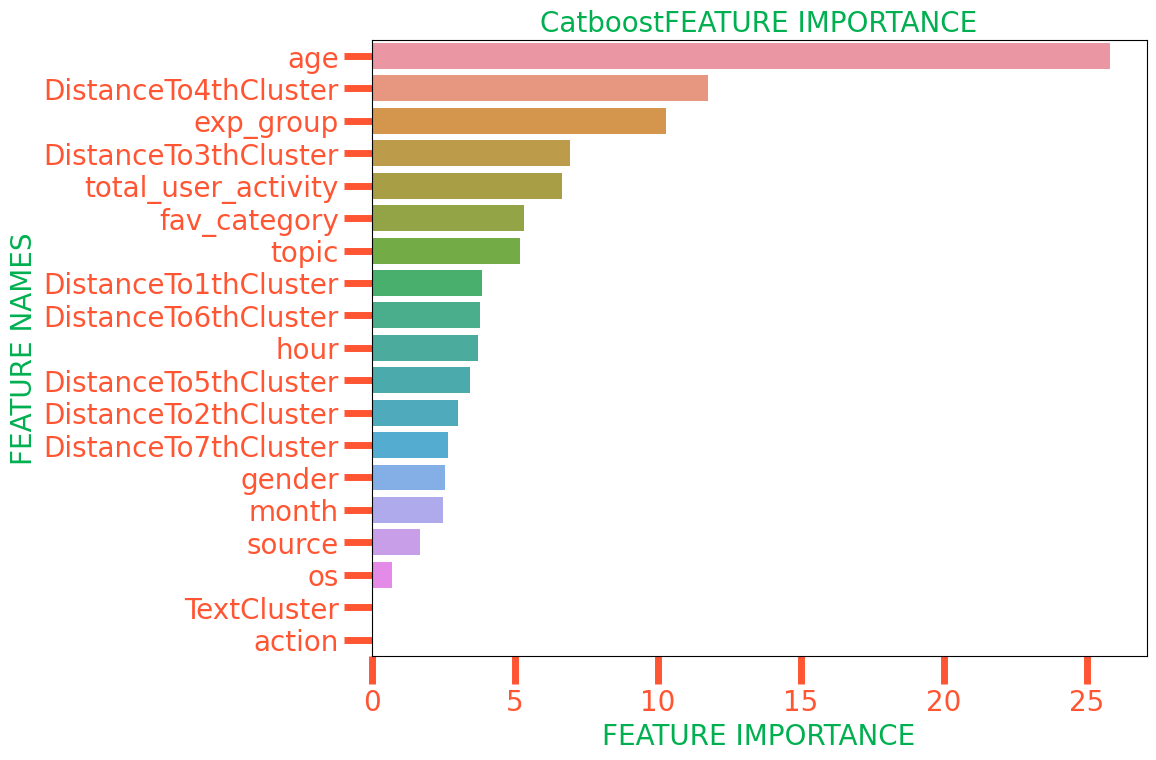

In [33]:
# let's look at the importance of variables to assess the contribution of each
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
plot_feature_importance(catboost.feature_importances_,X_train.columns,'Catboost')

Let's try to remove variables that contribute less

In [34]:
X_train_2 = X_train.drop(['gender', 'os', 'source', 'action', 'TextCluster', 'month'], axis=1)
X_test_2 = X_test.drop(['gender', 'os', 'source', 'action', 'TextCluster', 'month'], axis=1)

categotical_columns_2 = [i for i in categotical_columns if i in X_train_2.columns]

In [35]:
object_cols_2 = list(categotical_columns_2)

catboost_2 = CatBoostClassifier(iterations = 50)

catboost_2.fit(X_train_2, y_train, object_cols_2)

Learning rate set to 0.5
0:	learn: 0.4703386	total: 426ms	remaining: 20.9s
1:	learn: 0.3977399	total: 848ms	remaining: 20.4s
2:	learn: 0.3708892	total: 1.26s	remaining: 19.7s
3:	learn: 0.3602674	total: 1.64s	remaining: 18.9s
4:	learn: 0.3554062	total: 2s	remaining: 18s
5:	learn: 0.3529148	total: 2.36s	remaining: 17.3s
6:	learn: 0.3517538	total: 2.73s	remaining: 16.8s
7:	learn: 0.3509686	total: 3.09s	remaining: 16.2s
8:	learn: 0.3502683	total: 3.46s	remaining: 15.8s
9:	learn: 0.3499510	total: 3.81s	remaining: 15.2s
10:	learn: 0.3495275	total: 4.18s	remaining: 14.8s
11:	learn: 0.3493577	total: 4.55s	remaining: 14.4s
12:	learn: 0.3489145	total: 4.91s	remaining: 14s
13:	learn: 0.3486172	total: 5.28s	remaining: 13.6s
14:	learn: 0.3483250	total: 5.65s	remaining: 13.2s
15:	learn: 0.3482082	total: 6.03s	remaining: 12.8s
16:	learn: 0.3480389	total: 6.38s	remaining: 12.4s
17:	learn: 0.3478733	total: 6.75s	remaining: 12s
18:	learn: 0.3478695	total: 6.93s	remaining: 11.3s
19:	learn: 0.3476923	tota

In [36]:
print(f"Quality on train_2: {roc_auc_score(y_train, catboost_2.predict_proba(X_train_2)[:, 1])}")
print(f"Quality on test_2: {roc_auc_score(y_test, catboost_2.predict_proba(X_test_2)[:, 1])}")

Quality on train_2: 0.648603903483674
Quality on test_2: 0.6305610088127533


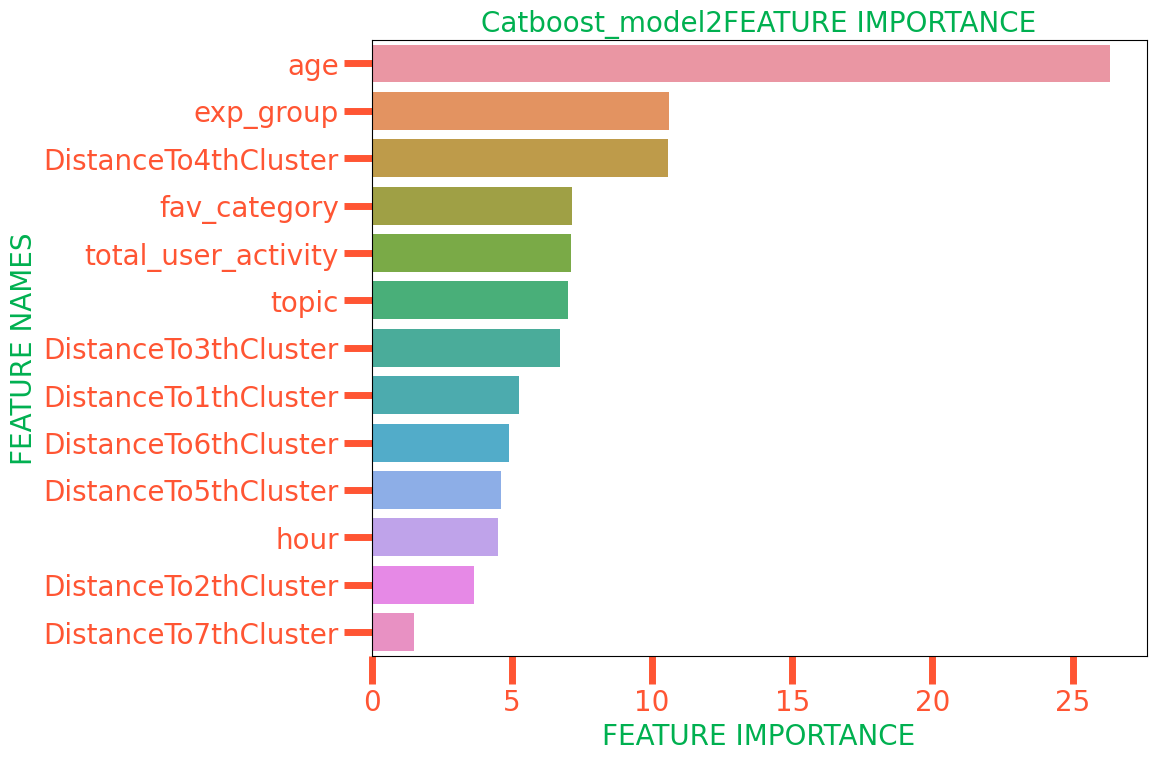

In [37]:
plot_feature_importance(catboost_2.feature_importances_,X_train_2.columns,'Catboost_model2')

# Loading data to server

In [38]:
catboost_2.save_model(
    'There is must be model name',
    format="cbm"                  

In [39]:
# #Connection to server
from sqlalchemy import create_engine

engine = create_engine(connection)

In [40]:
user_sql = user_data.iloc[:, [0,2,4,7,9]]
posts_sql = posts.drop([
    'MaxTfIdf', 'MeanTfIdf', 
    'TextCluster', 'DistanceTo7thCluster', 
    'DistanceTo8thCluster'
], axis=1)

In [41]:
user_sql.to_sql('There must be a name for users data', con=engine)
posts_sql.to_sql('There must be a name for posts data', con=engine)